In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import scipy.integrate

import numpy as np

import matplotlib.pyplot as plt

import math

import random

from mpmath import polylog

from sklearn.model_selection import train_test_split

import time

In [2]:
def generate_data(func, lower, upper, n_samples=100, n_dim=1):
    """
    Generates data in the form of a 2D (1D in case the function 
    is single-variable) tensor of variables for the function and neural network input
    as well as the function values for the generated tensor of variables.

    @param func      function to provide values for the variables
    @param lower     lower bounds of variables (list, tensor or scalar)
    @param upper     upper bounds of variables (list, tensor or scalar)
    @param n_samples number of points of data to generate
                     (default value is 100)
    @param n_dim     number of dimensions of the function func
                     (default value is 1)

    @returns         variables x and function values y
    """
    X_list = [torch.linspace(lower[n], upper[n], n_samples).view(n_samples, 1) for n in range(n_dim)]
    X = torch.cat(X_list, dim=1)
    
    y = func(X).view(n_samples, 1)
    
    return X, y

In [25]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, input_size, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs, verbose=True):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if verbose:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    total_time = time.time() - start_time  # Общее время обучения
    print(f'Training done! Time elapsed: {total_time:.2f} seconds')
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [4]:
def get_NN_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

# Oscillatory 1D

In [5]:
def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

def osc_1d_float(X):
    return math.cos(2 * math.pi * u + X * c)

In [102]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = 0.0
b = 1.0

In [7]:
u = random.uniform(0, 1)
cs = random.uniform(0, 1)
c = cs

def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

In [8]:
X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

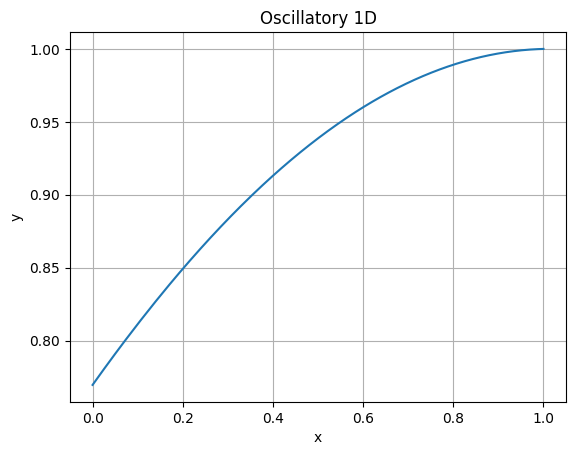

In [9]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Oscillatory 1D')
plt.grid(True)
plt.show()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [84]:
input_size = 1
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [12]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/10000], Loss: 0.3034799099
Epoch [200/10000], Loss: 0.0382060707
Epoch [300/10000], Loss: 0.0050184513
Epoch [400/10000], Loss: 0.0031865574
Epoch [500/10000], Loss: 0.0030448472
Epoch [600/10000], Loss: 0.0029306742
Epoch [700/10000], Loss: 0.0028088386
Epoch [800/10000], Loss: 0.0026804938
Epoch [900/10000], Loss: 0.0025469880
Epoch [1000/10000], Loss: 0.0024095811
Epoch [1100/10000], Loss: 0.0022694645
Epoch [1200/10000], Loss: 0.0021277736
Epoch [1300/10000], Loss: 0.0019856072
Epoch [1400/10000], Loss: 0.0018440254
Epoch [1500/10000], Loss: 0.0017040607
Epoch [1600/10000], Loss: 0.0015667146
Epoch [1700/10000], Loss: 0.0014329592
Epoch [1800/10000], Loss: 0.0013037273
Epoch [1900/10000], Loss: 0.0011799058
Epoch [2000/10000], Loss: 0.0010623160
Epoch [2100/10000], Loss: 0.0009517042
Epoch [2200/10000], Loss: 0.0008487136
Epoch [2300/10000], Loss: 0.0007538711
Epoch [2400/10000], Loss: 0.0006675595
Epoch [2500/10000], Loss: 0.0005900036
Epoch [2600/10000], Loss: 0.000521

In [13]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


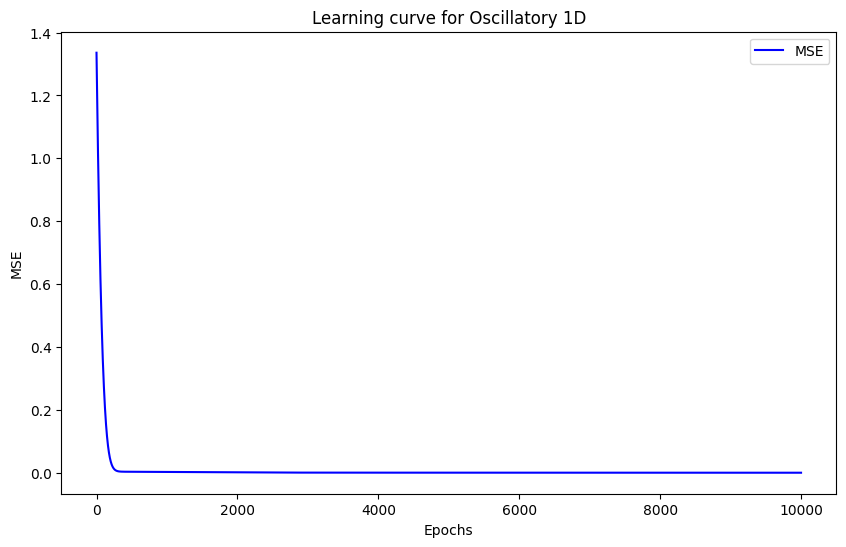

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [15]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000074669


In [16]:
bs1, we1, bs2, we2 = extract_model_params(model)

In [17]:
a = 0.0
b = 1.0

In [18]:
nni = get_NN_integral(a, b, bs1, we1, bs2, we2)

nni

array([mpf('0.92065453943337483')], dtype=object)

In [19]:
result, error = scipy.integrate.quad(osc_1d_float, a, b)

print("Integral:", result)
print("Error:", error)

Integral: 0.9206544594591427
Error: 1.022131778615368e-14


In [20]:
abs(float(nni[0]) - result)

7.997423212557919e-08

In [103]:
def test_osc_1d(index):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = 100 # / cs

    def osc_1d(X):
        return torch.cos(2 * math.pi * u + X * c)

    def osc_1d_float(X):
        return math.cos(2 * math.pi * u + X * c)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Oscillatory 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


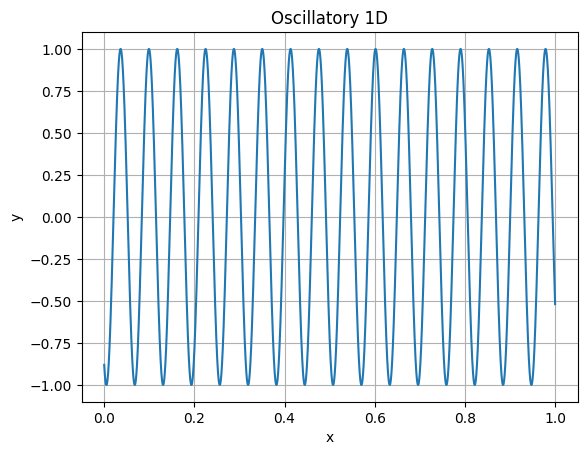

Training done! Time elapsed: 16.73 seconds
Test Loss: 0.5006138086
0.0038049733
Iteration 2 is running!


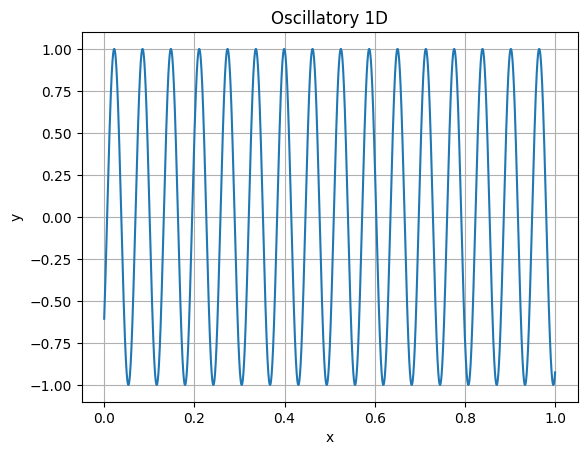

Training done! Time elapsed: 17.83 seconds
Test Loss: 0.4902213216
0.0041638566
Iteration 3 is running!


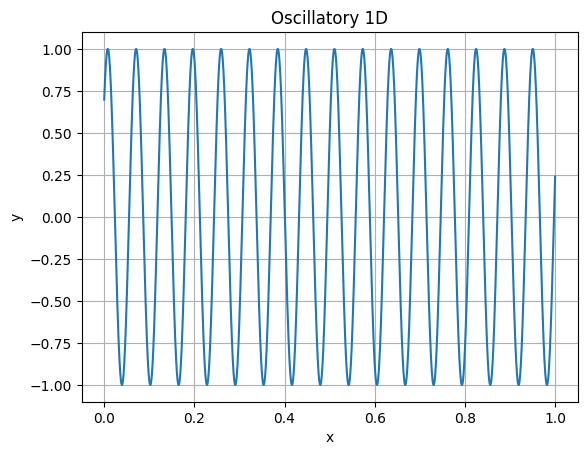

Training done! Time elapsed: 17.56 seconds
Test Loss: 0.4902039766
-0.0025500823
Iteration 4 is running!


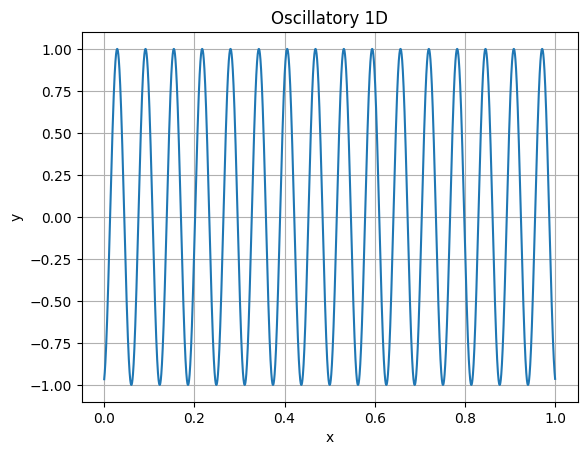

Training done! Time elapsed: 18.21 seconds
Test Loss: 0.5042611361
0.0052474113
Iteration 5 is running!


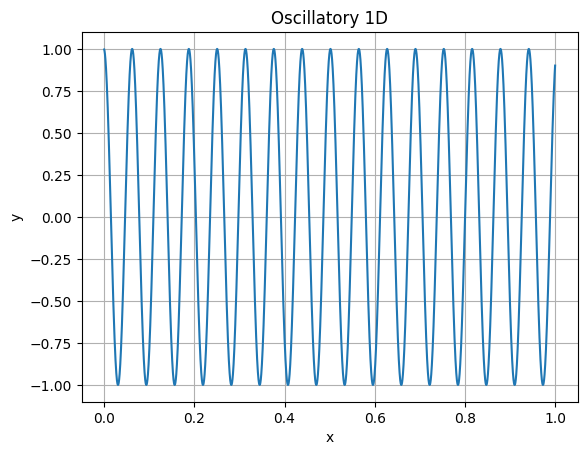

Training done! Time elapsed: 17.81 seconds
Test Loss: 0.5120554566
-0.005159107
Iteration 6 is running!


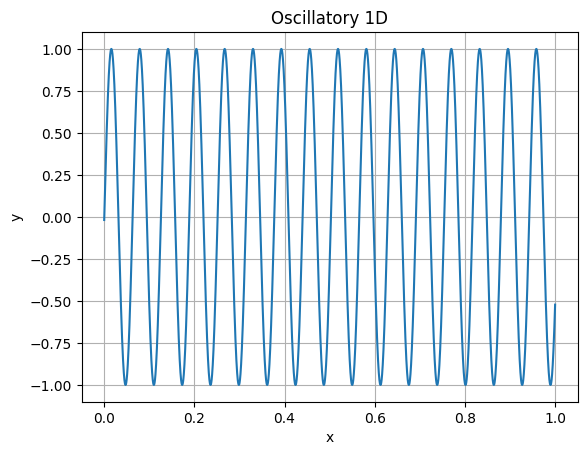

Training done! Time elapsed: 17.56 seconds
Test Loss: 0.4981442690
0.0014693998
Iteration 7 is running!


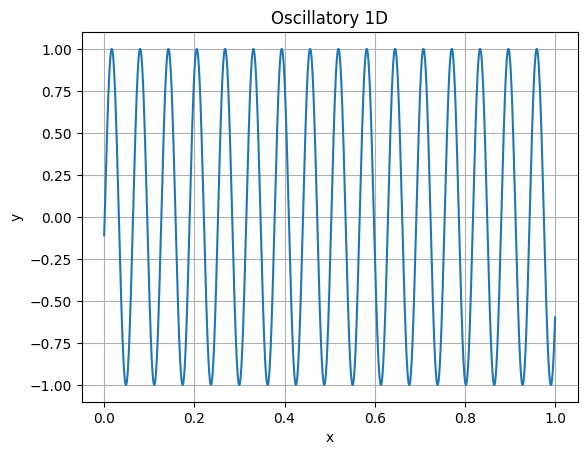

Training done! Time elapsed: 17.95 seconds
Test Loss: 0.4929085672
0.001924498
Iteration 8 is running!


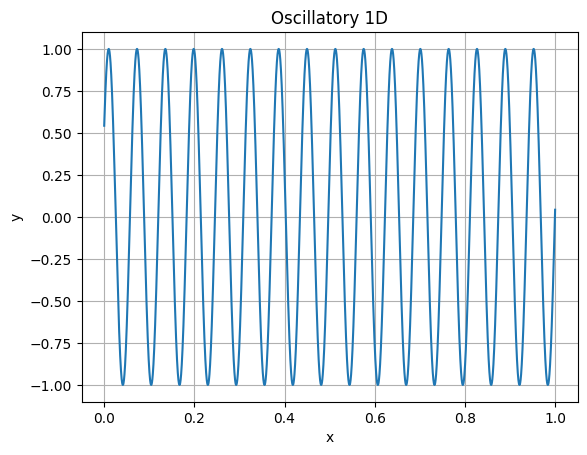

Training done! Time elapsed: 17.16 seconds
Test Loss: 0.4788174927
-0.001592325
Iteration 9 is running!


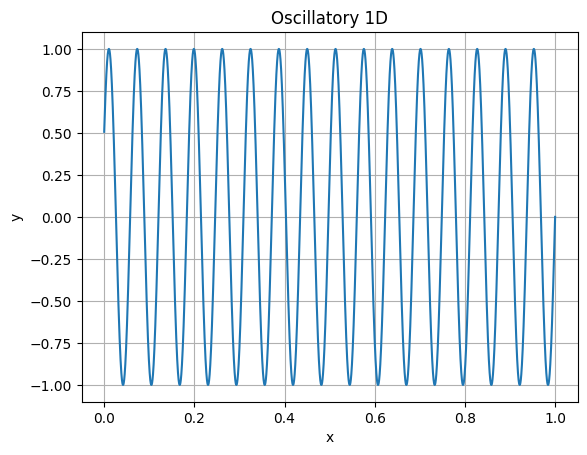

Training done! Time elapsed: 16.56 seconds
Test Loss: 0.4839911759
-0.001378296
Iteration 10 is running!


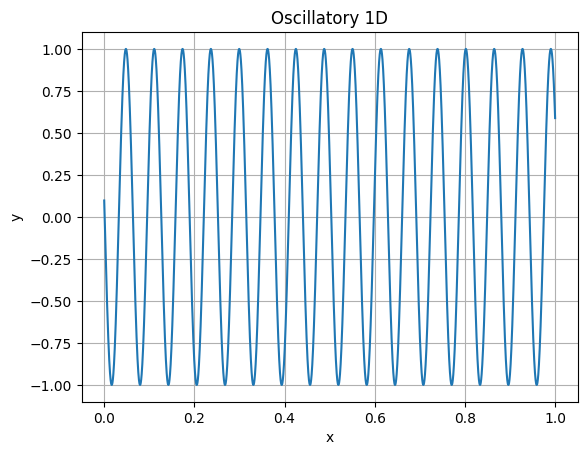

Training done! Time elapsed: 16.93 seconds
Test Loss: 0.4930598736
-0.001865143


In [104]:
results = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results.append(test_osc_1d(i))

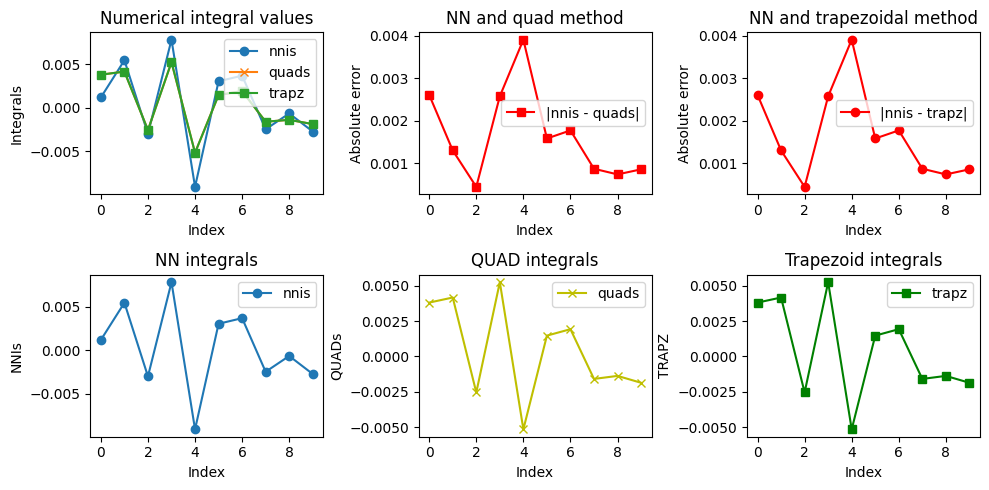

In [105]:
x_values = [i for i, _ in enumerate(results)]  # Index as x-axis
nnis = [v1 for v1, v2, v3 in results]
quads = [v2 for v1, v2, v3 in results]
trapz = [v3 for v1, v2, v3 in results]
abs_err_quad = [abs(v1 - v2) for v1, v2, v3 in results]
abs_err_trapz = [abs(v1 - v3) for v1, v2, v3 in results]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))

ax1.plot(x_values, nnis, label='nnis', marker='o')
ax1.plot(x_values, quads, label='quads', marker='x')
ax1.plot(x_values, trapz, label='trapz', marker='s')
ax1.set_xlabel('Index')
ax1.set_ylabel('Integrals')
ax1.set_title('Numerical integral values')
ax1.legend()

ax2.plot(x_values, abs_err_quad, label='|nnis - quads|', marker='s', color='red')
ax2.set_xlabel('Index')
ax2.set_ylabel('Absolute error')
ax2.set_title('NN and quad method')
ax2.legend()

ax3.plot(x_values, abs_err_trapz, label='|nnis - trapz|', marker='o', color='red')
ax3.set_xlabel('Index')
ax3.set_ylabel('Absolute error')
ax3.set_title('NN and trapezoidal method')
ax3.legend()

ax4.plot(x_values, nnis, label='nnis', marker='o')
ax4.set_xlabel('Index')
ax4.set_ylabel('NNIs')
ax4.set_title('NN integrals')
ax4.legend()

ax5.plot(x_values, quads, label='quads', marker='x', color='y')
ax5.set_xlabel('Index')
ax5.set_ylabel('QUADs')
ax5.set_title('QUAD integrals')
ax5.legend()

ax6.plot(x_values, trapz, label='trapz', marker='s', color='g')
ax6.set_xlabel('Index')
ax6.set_ylabel('TRAPZ')
ax6.set_title('Trapezoid integrals')
ax6.legend()

plt.tight_layout()
plt.show()

In [106]:
def test_prod_peek_1d(index):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = 150 # / cs

    def osc_1d(X):
        return 1 / (c**(-2) + (X - u)**2)

    def osc_1d_float(X):
        return 1 / (c**(-2) + (X - u)**2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Product peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


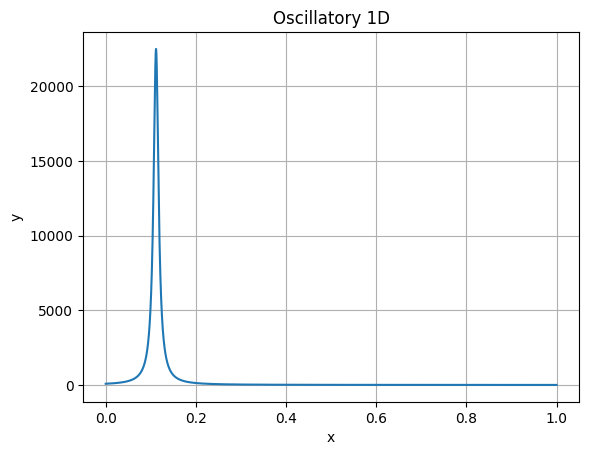

Training done! Time elapsed: 17.16 seconds
Test Loss: 4601108.0000000000
461.16632
Iteration 2 is running!


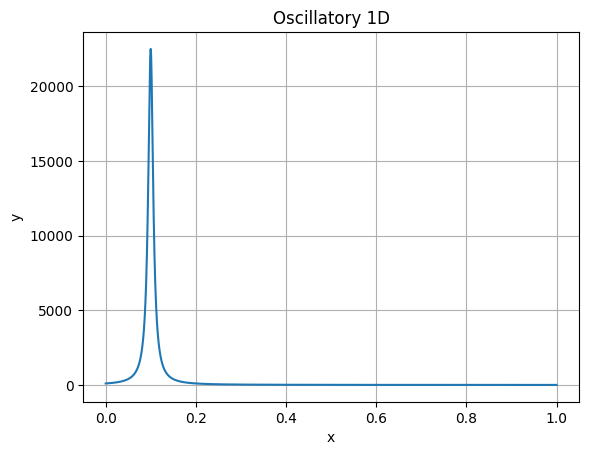

Training done! Time elapsed: 16.93 seconds
Test Loss: 5745578.5000000000
460.12027
Iteration 3 is running!


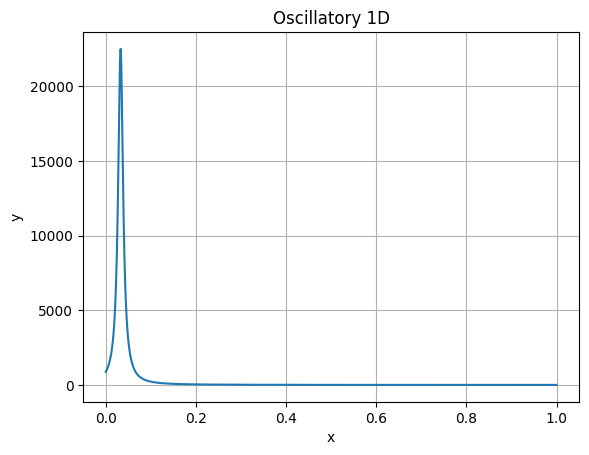

Training done! Time elapsed: 16.97 seconds
Test Loss: 3217560.5000000000
440.35184
Iteration 4 is running!


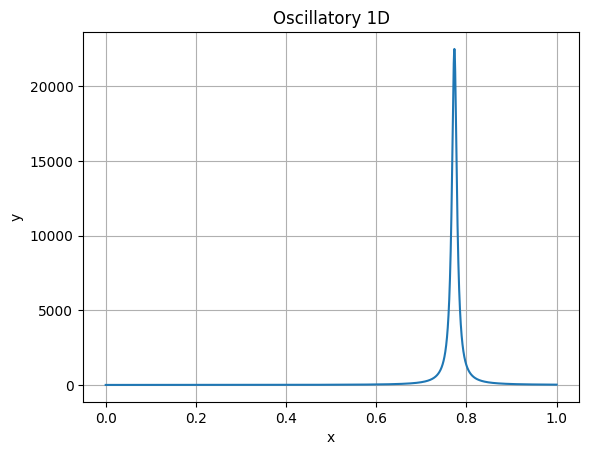

Training done! Time elapsed: 16.39 seconds
Test Loss: 6765960.5000000000
465.536
Iteration 5 is running!


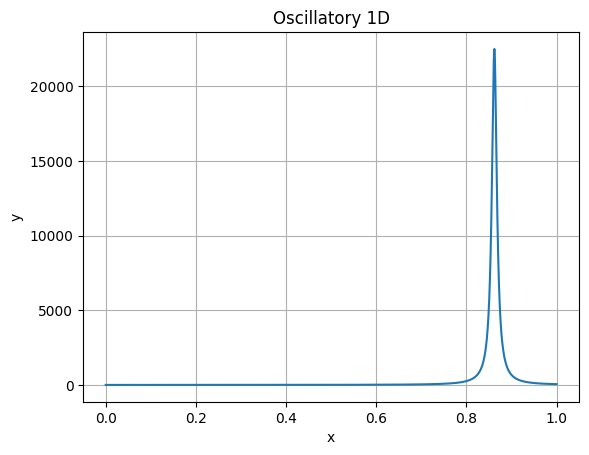

Training done! Time elapsed: 16.30 seconds
Test Loss: 5041431.0000000000
462.8403
Iteration 6 is running!


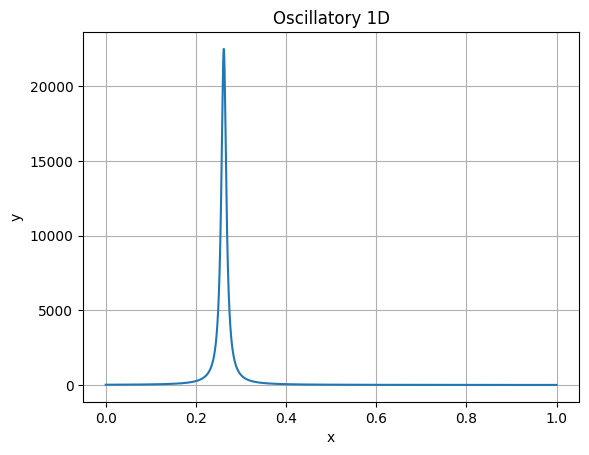

Training done! Time elapsed: 16.28 seconds
Test Loss: 3808652.7500000000
466.06674
Iteration 7 is running!


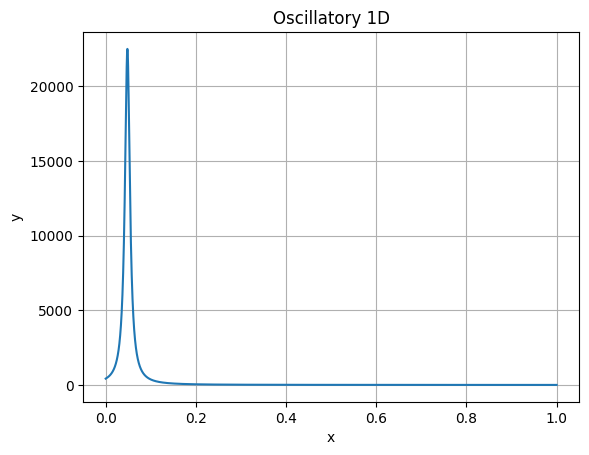

Training done! Time elapsed: 16.87 seconds
Test Loss: 6299644.5000000000
449.5419
Iteration 8 is running!


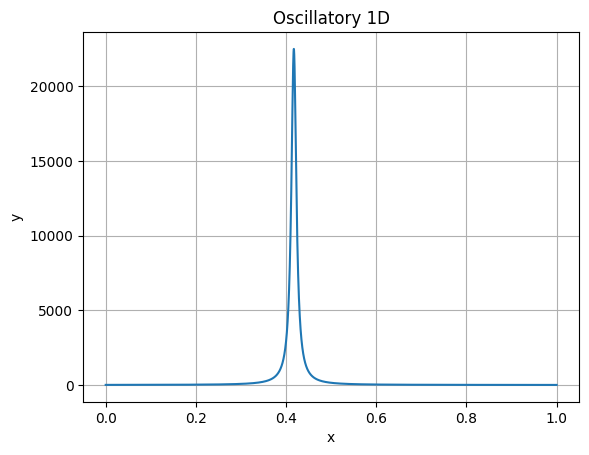

Training done! Time elapsed: 16.43 seconds
Test Loss: 2479102.7500000000
467.1265
Iteration 9 is running!


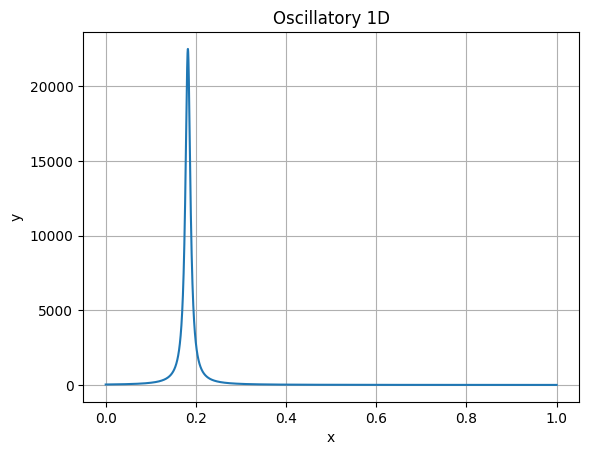

Training done! Time elapsed: 16.39 seconds
Test Loss: 5132468.0000000000
464.53214
Iteration 10 is running!


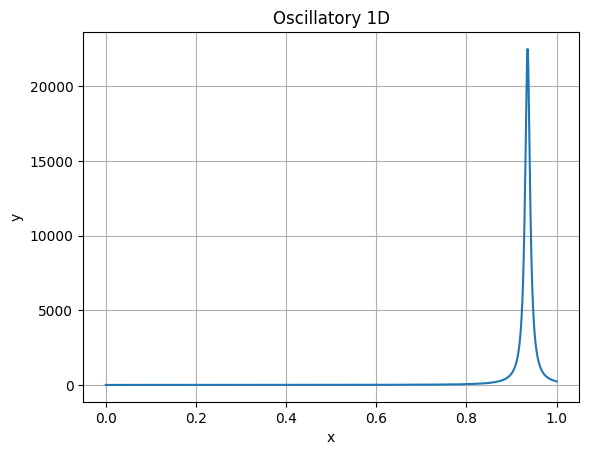

Training done! Time elapsed: 16.53 seconds
Test Loss: 5371356.0000000000
454.69943


In [107]:
results2 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results2.append(test_prod_peek_1d(i))

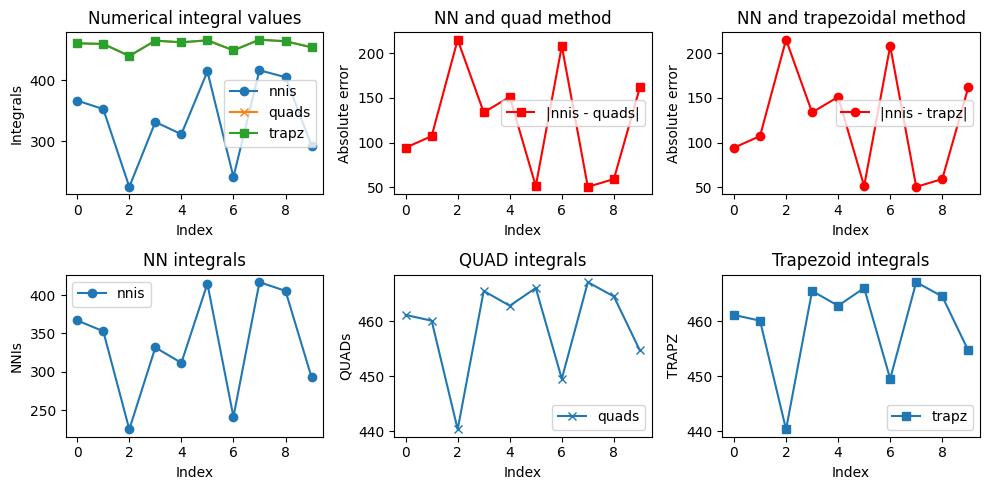

In [108]:
x_values = [i for i, _ in enumerate(results2)]  # Index as x-axis
nnis = [v1 for v1, v2, v3 in results2]
quads = [v2 for v1, v2, v3 in results2]
trapz = [v3 for v1, v2, v3 in results2]
abs_err_quad = [abs(v1 - v2) for v1, v2, v3 in results2]
abs_err_trapz = [abs(v1 - v3) for v1, v2, v3 in results2]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))

ax1.plot(x_values, nnis, label='nnis', marker='o')
ax1.plot(x_values, quads, label='quads', marker='x')
ax1.plot(x_values, trapz, label='trapz', marker='s')
ax1.set_xlabel('Index')
ax1.set_ylabel('Integrals')
ax1.set_title('Numerical integral values')
ax1.legend()

ax2.plot(x_values, abs_err_quad, label='|nnis - quads|', marker='s', color='red')
ax2.set_xlabel('Index')
ax2.set_ylabel('Absolute error')
ax2.set_title('NN and quad method')
ax2.legend()

ax3.plot(x_values, abs_err_trapz, label='|nnis - trapz|', marker='o', color='red')
ax3.set_xlabel('Index')
ax3.set_ylabel('Absolute error')
ax3.set_title('NN and trapezoidal method')
ax3.legend()

ax4.plot(x_values, nnis, label='nnis', marker='o')
ax4.set_xlabel('Index')
ax4.set_ylabel('NNIs')
ax4.set_title('NN integrals')
ax4.legend()

ax5.plot(x_values, quads, label='quads', marker='x', color='y')
ax5.set_xlabel('Index')
ax5.set_ylabel('QUADs')
ax5.set_title('QUAD integrals')
ax5.legend()

ax6.plot(x_values, trapz, label='trapz', marker='s', color='g')
ax6.set_xlabel('Index')
ax6.set_ylabel('TRAPZ')
ax6.set_title('Trapezoid integrals')
ax6.legend()

plt.tight_layout()
plt.show()

In [115]:
def test_corn_peek_1d(index):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = 600 * cs

    def corn_peek_1d(X):
        return (1 + c * x) ** (-2)

    def corn_peek_float(X):
        return (1 + c * x) ** (-2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Corner Peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


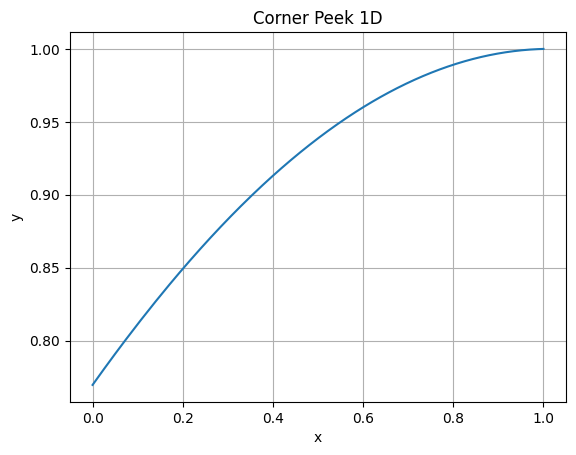

Training done! Time elapsed: 17.60 seconds
Test Loss: 0.0001665585
0.92065436
Iteration 2 is running!


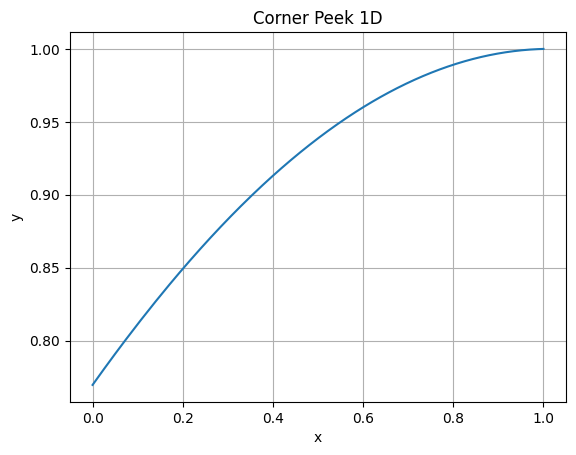

Training done! Time elapsed: 17.74 seconds
Test Loss: 0.0000007283
0.92065436
Iteration 3 is running!


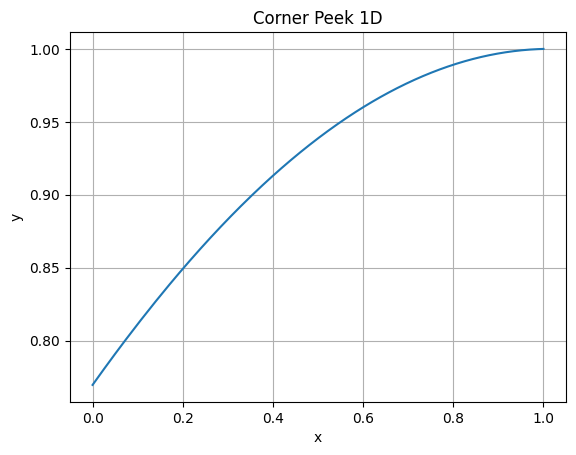

Training done! Time elapsed: 18.36 seconds
Test Loss: 0.0001401906
0.92065436
Iteration 4 is running!


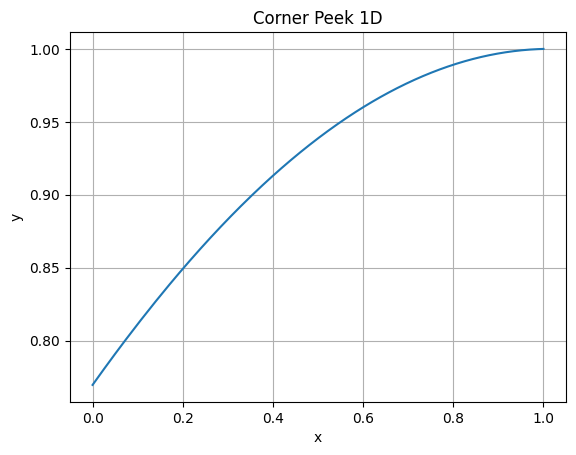

Training done! Time elapsed: 17.55 seconds
Test Loss: 0.0000519043
0.92065436
Iteration 5 is running!


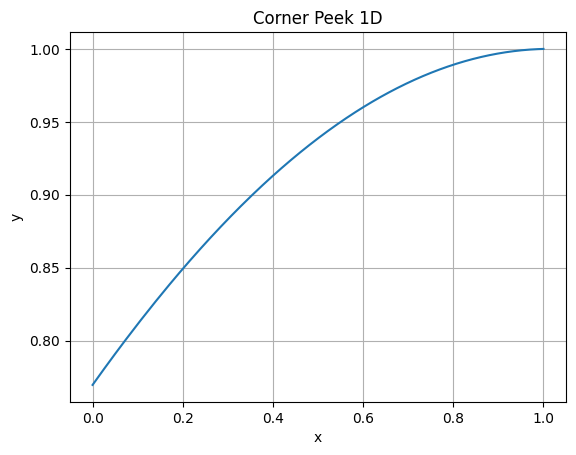

Training done! Time elapsed: 19.30 seconds
Test Loss: 0.0001908565
0.92065436
Iteration 6 is running!


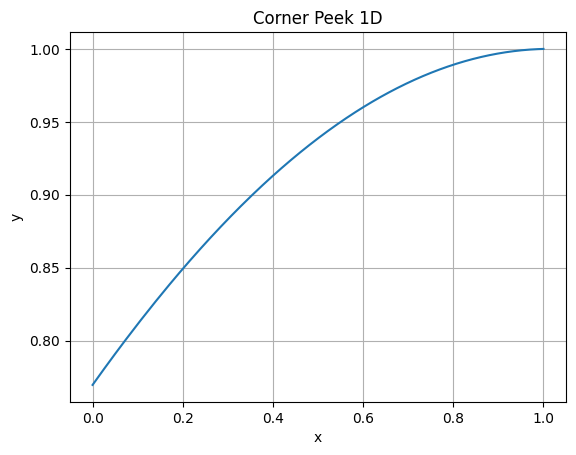

Training done! Time elapsed: 18.77 seconds
Test Loss: 0.0000364258
0.92065436
Iteration 7 is running!


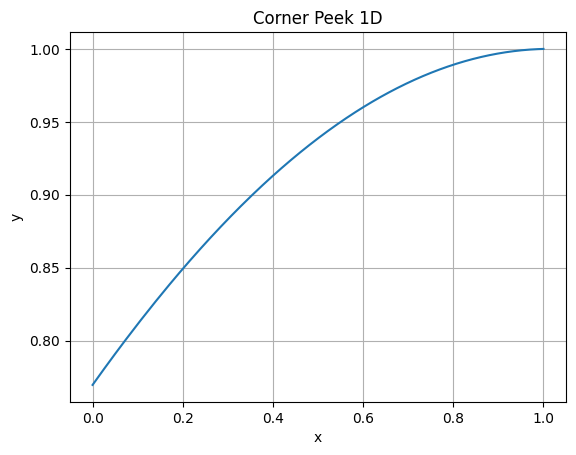

Training done! Time elapsed: 18.22 seconds
Test Loss: 0.0000007057
0.92065436
Iteration 8 is running!


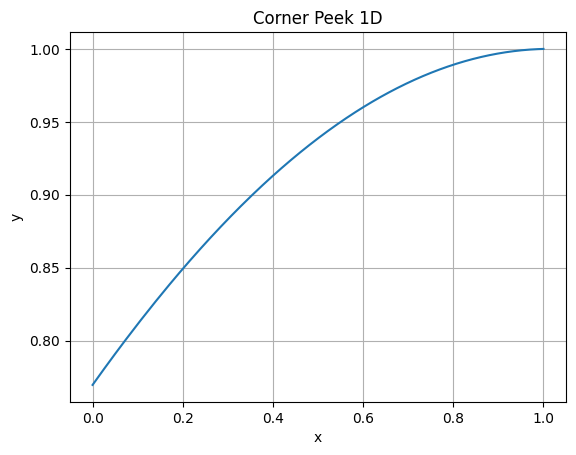

Training done! Time elapsed: 18.46 seconds
Test Loss: 0.0000879394
0.92065436
Iteration 9 is running!


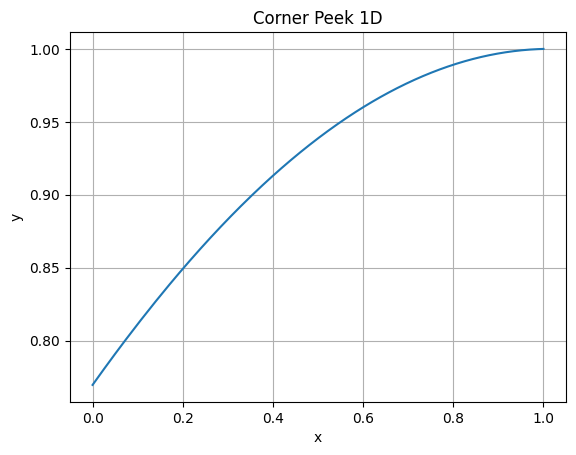

Training done! Time elapsed: 19.01 seconds
Test Loss: 0.0001355906
0.92065436
Iteration 10 is running!


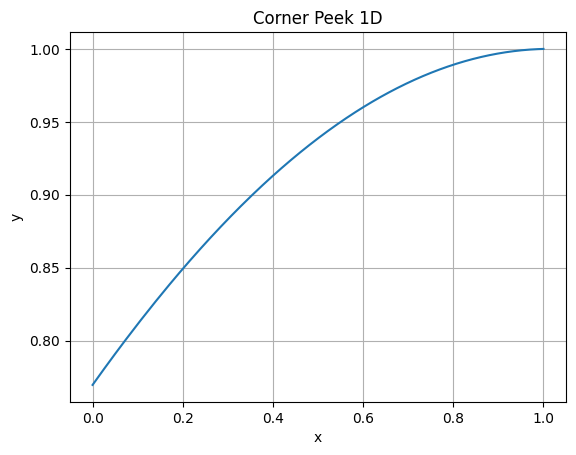

Training done! Time elapsed: 18.94 seconds
Test Loss: 0.0000986758
0.92065436


In [116]:
results3 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results3.append(test_corn_peek_1d(i))

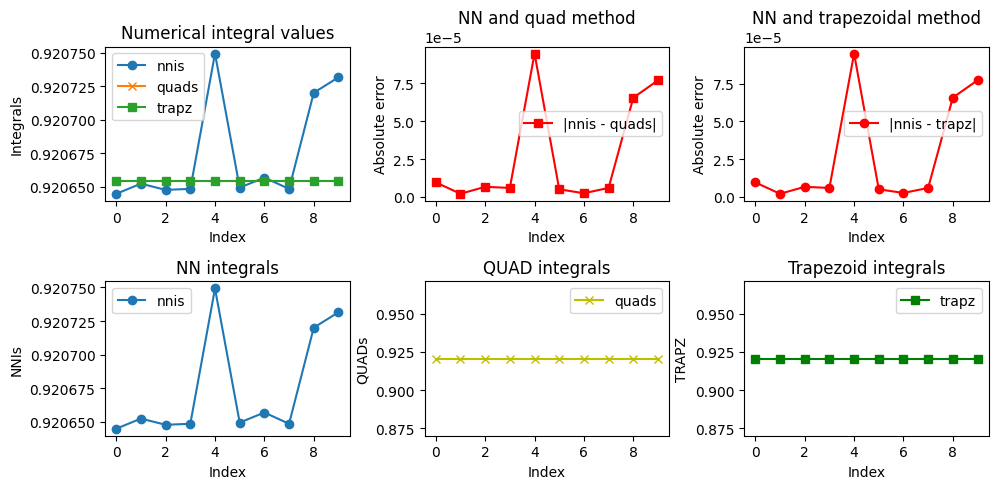

In [117]:
x_values = [i for i, _ in enumerate(results3)]  # Index as x-axis
nnis = [v1 for v1, v2, v3 in results3]
quads = [v2 for v1, v2, v3 in results3]
trapz = [v3 for v1, v2, v3 in results3]
abs_err_quad = [abs(v1 - v2) for v1, v2, v3 in results3]
abs_err_trapz = [abs(v1 - v3) for v1, v2, v3 in results3]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))

ax1.plot(x_values, nnis, label='nnis', marker='o')
ax1.plot(x_values, quads, label='quads', marker='x')
ax1.plot(x_values, trapz, label='trapz', marker='s')
ax1.set_xlabel('Index')
ax1.set_ylabel('Integrals')
ax1.set_title('Numerical integral values')
ax1.legend()

ax2.plot(x_values, abs_err_quad, label='|nnis - quads|', marker='s', color='red')
ax2.set_xlabel('Index')
ax2.set_ylabel('Absolute error')
ax2.set_title('NN and quad method')
ax2.legend()

ax3.plot(x_values, abs_err_trapz, label='|nnis - trapz|', marker='o', color='red')
ax3.set_xlabel('Index')
ax3.set_ylabel('Absolute error')
ax3.set_title('NN and trapezoidal method')
ax3.legend()

ax4.plot(x_values, nnis, label='nnis', marker='o')
ax4.set_xlabel('Index')
ax4.set_ylabel('NNIs')
ax4.set_title('NN integrals')
ax4.legend()

ax5.plot(x_values, quads, label='quads', marker='x', color='y')
ax5.set_xlabel('Index')
ax5.set_ylabel('QUADs')
ax5.set_title('QUAD integrals')
ax5.legend()

ax6.plot(x_values, trapz, label='trapz', marker='s', color='g')
ax6.set_xlabel('Index')
ax6.set_ylabel('TRAPZ')
ax6.set_title('Trapezoid integrals')
ax6.legend()

plt.tight_layout()
plt.show()